## Get Started: A Quick Example
Here is a simple time series example with GluonTS for predicting Twitter volume with DeepAR.

In [ ]:
!pip install gluonts

In [4]:
from gluonts.dataset import common
from gluonts.model import deepar
from gluonts.mx.trainer import Trainer

Import direct historical TS dataset. This simple example illustrates how to train a model from GluonTS on some data, and then use it to make predictions. As a first step, we need to collect some data: in this example we will use the volume of tweets mentioning the AMZN ticker symbol.

In [12]:
import pandas as pd
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv"
df = pd.read_csv(url, header=0, index_col=0)

The first 100 data points look like follows:

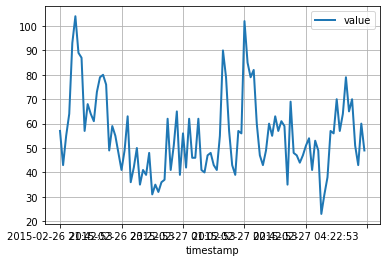

In [13]:
import matplotlib.pyplot as plt
df[:100].plot(linewidth=2)
plt.grid(which='both')
plt.show()

In [14]:
df.head(3)

,value
timestamp,
2015-02-26 21:42:53,57
2015-02-26 21:47:53,43
2015-02-26 21:52:53,55


Notice in the output above there are 2 columns of data:

1. The Timestamp

2. A Value

In [15]:
df.describe()

,value
count,15831.000000
mean,53.298465
std,30.553147
min,0.000000
25%,36.000000
50%,50.000000
75%,65.000000
max,1673.000000


We can now prepare a training dataset for our model to train on. Datasets in GluonTS are essentially iterable collections of dictionaries: each dictionary represents a time series with possibly associated features. For this example, we only have one entry, specified by the "start" field which is the timestamp of the first datapoint, and the "target" field containing time series data. For training, we will use data up to midnight on April 5th, 2015.

In [18]:
from gluonts.dataset.common import ListDataset
training_data = ListDataset(
    [{"start": df.index[0], "target": df.value[:"2015-04-05 00:00:00"]}],
    freq = "5min"
)

Now let's train a TS predictor using a gluonTS built-in algorithm DeepAR. During training, useful information about the progress will be displayed. To get a full overview of the available options, please refer to the documentation of DeepAREstimator (or other estimators) and Trainer.

In [20]:
%%time
estimator = deepar.DeepAREstimator(
    freq="5min", prediction_length=12, trainer=Trainer(epochs=10))
predictor = estimator.train(training_data=data)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:02<00:00, 23.68it/s, epoch=10/10, avg_epoch_loss=3.96]

CPU times: user 21.2 s, sys: 1.79 s, total: 23 s
Wall time: 22.3 s


In [21]:
prediction = next(predictor.predict(data))
print(prediction.mean)

[51.085243 46.408974 43.886646 40.543427 40.621094 44.599693 43.75963
 41.93263  41.916447 43.223125 45.60345  44.41809 ]


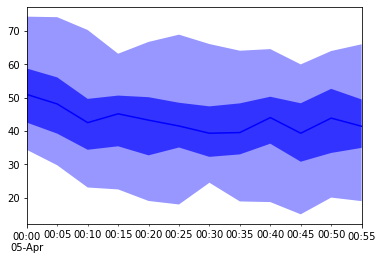

In [9]:
prediction.plot(output_file='graph.png')

We're now ready to make predictions: we will forecast the hour following the midnight on April 15th, 2015.

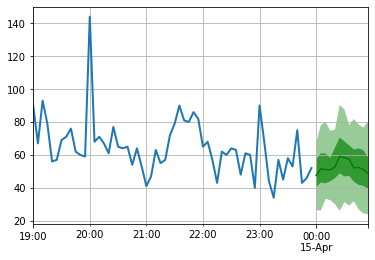

In [22]:
test_data = ListDataset(
    [{"start": df.index[0], "target": df.value[:"2015-04-15 00:00:00"]}],
    freq = "5min"
)

from gluonts.dataset.util import to_pandas

for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
    to_pandas(test_entry)[-60:].plot(linewidth=2)
    forecast.plot(color='g', prediction_intervals=[50.0, 90.0])
plt.grid(which='both')

Note that the forecast is displayed in terms of a probability distribution: the shaded areas represent the 50% and 90% prediction intervals, respectively, centered around the median (dark green line).